# Cuaderno de Notas de Métodos Numéricos
## Diferenciación numérica (fórmulas básicas)
### Prof. Jorge I. Zuluaga


#### Ejecutarme siempre

A continuación descargamos en el espacio virtual de este cuaderno todos los archivos necesarios para que las notas del curso funcionen bien:

In [ ]:
!git clone https://github.com/JorgeZuluaga/NotasMetodosNumericos
!ln -s NotasMetodosNumericos mn
!make -C mn pull

Cloning into 'NotasMetodosNumericos'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 108 (delta 46), reused 82 (delta 20), pack-reused 0
Receiving objects: 100% (108/108), 8.53 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (46/46), done.
make: Entering directory '/content/NotasMetodosNumericos'
git reset --hard HEAD
HEAD is now at 876de31 Commit
git pull origin master
From https://github.com/JorgeZuluaga/NotasMetodosNumericos
 * branch            master     -> FETCH_HEAD
Already up to date.
make: Leaving directory '/content/NotasMetodosNumericos'


## Un vistazo de la clase

  Qué veremos en esta clase:

  - Motivación.
  - Diferenciación numérica: fórmula básica.
  - Complemento: interpolación por splines cúbicos con Python.

  Para leer en el libro: sección 4.1 "Diferenciación numérica" hasta el Ejemplo 1.

## Motivación

- En los cursos de cálculo aprendimos a hacer operaciones sobre funciones, especialmente la derivada y la antiderivada (integral).  

- Estas operaciones se pueden realizar siempre que tengamos una función y que esa función sea suficientemente sencilla.  

- Pero ¿qué pasa si no tenemos la forma de la función o si la función es increíblemente complicada?.

- Por ejemplo, cuando trabajamos con series de datos, no tenemos la función, solo un conjunto de valores de la misma.  ¿Cómo sacar la derivada en ese caso?.

- Para ilustrar el problema que tenemos entre manos, vamos a traer del mundo de la interpolación una situación concreta:

### Trabajando con datos reales

- El método de interpolación de Hermite surgió para corregir el defecto de la interpolación de Lagrange que a veces producía picos artificiales.

- La interpolación con diferencias divididas no resuelve el problema como veremos a continuación.

- El procedimiento que veremos aquí ya lo vimos en el cuaderno [Interpolación: datos reales y errores](https://colab.research.google.com/drive/1D8oJURcGl8AksIOCUeYRxX3hOow_KLH0?usp=sharing).

- Primero descargamos los datos de temperatura que vamos a usar:

In [ ]:
!curl -O https://raw.githubusercontent.com/JorgeZuluaga/NotasMetodosNumericos/master/datos/dataexport_20220330T141717.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   523  100   523    0     0   3510      0 --:--:-- --:--:-- --:--:--  3510


- Ahora leemos los datos como apendimos antes

In [ ]:
import numpy as np
import pandas as pd
#Leemos los datos
datos=pd.read_csv("dataexport_20220330T141717.csv",skiprows=9)
#Convertimos las fechas en horas desde el primer dato
xs=np.array(pd.to_datetime(datos['timestamp']).view(int)/1e9/3600)
xs=xs-xs[0]
#Extraemos las temperaturas
fs=np.array(datos["Medellín Temperature [2 m elevation corrected]"])

- Aquí hay un gráfico de los datos:

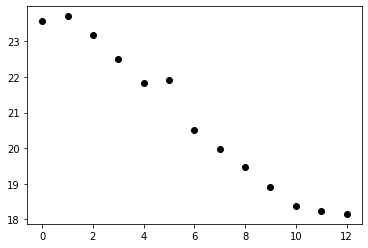

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xs,fs,'ko')

- Pregúntemonos, **¿podríamos sacar la derivada de la función que hay detrás de esos datos?**.

- Hagamos ahora la interpolación usando diferencias divididas.  Para ello necesitamos el algoritmo que habíamos escrito antes:

In [ ]:
def diferencias_divididas(xs,fs):
  import sympy as sp
  import numpy as np
  from prettytable import PrettyTable
  #Orden del polinomio
  n=len(xs)-1
  #Crea la matriz de los valores
  F=np.ones((n+1,n+1))*np.nan
  #Inicia la primera columna
  F[0,0]=fs[0]
  for i in range(1,n+1):
    F[i,0]=fs[i]
  #Llena la tabla
  for i in range(1,n+1):
    for j in range(1,i+1):
      F[i,j]=(F[i,j-1]-F[i-1,j-1])/(xs[i]-xs[i-j])
  #Crea el polinomio
  x=sp.symbols("x")
  Pn=F[0,0]
  for k in range(1,n+1):
    factor=1
    for i in range(k):
      factor*=(x-xs[i])
    Pn+=F[k,k]*factor
  Pn=sp.expand(Pn)
  #Crea la función
  Pfun=sp.lambdify(x,Pn)
  #Vamos a crear la tabla
  N=len(xs)
  head=["x"]
  for i in range(N):
    head+=[f"f[{''.join((',',)*i)}]"]
  tabla=PrettyTable(head)
  for i in range(N):
    row=[f"{xs[i]}",f"{F[i,0]}"]
    for j in range(1,N):
      row+=[f"{F[i][j]:.6f}"] if not np.isnan(F[i][j]) else ["-"]
    tabla.add_row(row)
  return F,tabla,Pn,Pfun

- Ahora si podemos hacer la interpolación:

In [ ]:
F,tabla,Pn,Pfun=diferencias_divididas(xs,fs)

- Aquí está la tabla de diferencias divididas:

In [ ]:
print(tabla)

+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+-------------+--------------+---------------+----------------+-----------------+
|  x   |    f[]    |    f[,]   |   f[,,]   |   f[,,,]  |  f[,,,,]  |  f[,,,,,] | f[,,,,,,] | f[,,,,,,,] | f[,,,,,,,,] | f[,,,,,,,,,] | f[,,,,,,,,,,] | f[,,,,,,,,,,,] | f[,,,,,,,,,,,,] |
+------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+-------------+--------------+---------------+----------------+-----------------+
| 0.0  | 23.589214 |     -     |     -     |     -     |     -     |     -     |     -     |     -      |      -      |      -       |       -       |       -        |        -        |
| 1.0  | 23.709213 |  0.119999 |     -     |     -     |     -     |     -     |     -     |     -      |      -      |      -       |       -       |       -        |        -        |
| 2.0  | 23.189215 | -0.519998 | -0.319998 |     -     |     -     |  

- Grafiquemos el polinomio resultante (como aprendimos hacerlo en el otro cuaderno):

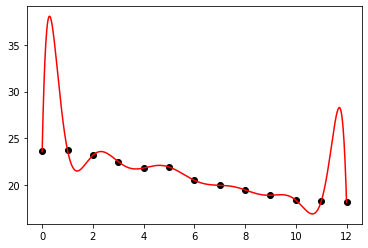

In [ ]:
import matplotlib.pyplot as plt
xns=np.linspace(xs[0],xs[-1],1000)
fns=Pfun(xns)

plt.plot(xs,fs,'ko')
plt.plot(xns,fns,'r-')

- Como vemos los problemas persisten.  ¡Claro! es que el algoritmo de diferencias divididas es el mismo de la interpolación de Lagrange, pero usando diferencias divididas en lugar de los coeficientes $L_{n,m}$.

- Probemos ahora con los polinomios de Hermite.  

- ¡Hay un problema!: **para usar esos polinomios necesitamos ahora la derivada de la función en cada punto, y los datos climáticos no la proveen**.

## La primera derivada numérica

- Sabemos del cálculo que la derivada se define como:

 $$
 f^{\prime}\left(x_{0}\right)=\lim _{h \rightarrow 0} \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h}
 $$

- Una primera idea para aproximar la derivada de una función es usar la fórmula:

 $$
 f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h}
 $$

  En la figura abajo se muestra la interpretación geométrica de este operación:

  <center>
  <img src="https://raw.githubusercontent.com/JorgeZuluaga/NotasMetodosNumericos/master/figuras/derivada-hacia-adelante.png" width=400>
  </center>

- Nótese que está fórmula es equivalente a la diferencia de orden 1 $f[x_0,x_0+h]$ que vimos antes, de modo que la fórmula aproximada de la primera derivada también se puede escribir de la forma:

 $$
 f^{\prime}\left(x_{0}\right)\approx f[x_0,x_0+h]
 $$

- El mismo razonamiento se puede aplicar tomando el punto anterior a $x_0$ así:

 $$
 f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}\right)-f\left(x_{0}-h\right)}{h}
 $$

- Incluso podemos usar el punto posterior $x_0+h$ y el punto anterior $x_0-h$.  En este caso sin embargo, la diferencia entre los dos puntos es $2h$:

 $$
 f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}+h\right)-f\left(x_{0}-h\right)}{2h}
 $$

- Dependiendo de si el punto que se usa es el punto de adelante $x_0+h$ o el de atrás, la fórmula simple numérica para calcular la derivada se llama:

 - Fórmula de **diferencia hacia adelante**:
 
   $$
 f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h}
 $$

 - Fórmula de **diferencia hacia atrás**:

   $$
 f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}\right)-f\left(x_{0}-h\right)}{h}
 $$

  - Fórmula de **diferencia central**:

   $$
 f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}+h\right)-f\left(x_{0}-h\right)}{2h}
 $$

- En las figuras abajo se muestran las interpretaciones geométricas entre las diferencias hacia atrás y central con las diferencias hacia adelante:

  <center>
  <img src="https://raw.githubusercontent.com/JorgeZuluaga/NotasMetodosNumericos/master/figuras/derivada-hacia-atras-central.png" width=600>
  </center>

### Un ejemplo simple

- **Ejemplo**.  Use la fórmula de diferencia hacia adelante, diferencia hacia atrás y central para estimar la primera derivada de $f(x)=\tan[ln(1/x+x)]|^{1/3}$ en $x_0=2$ usando $h=0.01$.  
  
  - **Solución**: 

    - Nótese que la función que tenemos entre manos es tan compleja, que el cálculo de la derivada por métodos convencionales se hace muy difícil.  Para esto se usa la aproximación de la derivada.

    - Para calcular la fórmula con diferencia hacia adelante debemos evaluar la función en $x_0=2$ y en $x_0+h=2.01$:

     $$
     f(x_0)=f(2)=1.092289
     $$
     y 
     $$
     f(x_0+h)=f(2.01)=1.0945555
     $$

    - La derivada es:

     $$
     f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h}=\frac{1.0945555-1.092289}{0.01}=0.22665
     $$

    - Para calcular la fórmula con diferencia hacia atrás debemos evaluar la función en $x_0=2$ y en $x_0-h=1.99$:

     $$
     f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}\right)-f\left(x_{0}-h\right)}{h}=\frac{1.092289-1.090032}{0.01}=0.2257
     $$

    - Para calcular la fórmula con diferencia centraldebemos evaluar la función en $x_0+h=2.01$ y en $x_0-h=1.99$:

     $$
     f^{\prime}\left(x_{0}\right)\approx \frac{f\left(x_{0}+h\right)-f\left(x_{0}-h\right)}{2h}=\frac{1.0945555-1.090032}{0.02}=0.226175
     $$
    - Podemos verificar este resultado usando `SymPy`:

In [ ]:
import sympy as sp
x=sp.symbols("x")
f=sp.tan(sp.log(1/x+x))**(1/3)
fp=sp.diff(f,x)
fp

0.333333333333333*(1 - 1/x**2)*(tan(log(x + 1/x))**2 + 1)*tan(log(x + 1/x))**(-0.666666666666667)/(x + 1/x)

Pero este resultado no sirve si no evaluamos la función en $x_0=2$:

In [ ]:
sp.N(fp.subs(x,2))

0.226163369419159

Vemos que los resultado del cálculo numérico en el ejemplo arriba coinciden bien con el valor exacto.  Sin embargo el que mejor coincide es la **fórmula con diferencia central**.

## Aplicación de la derivada numérica a datos

- Ahora que tenemos manera de calcular la derivada usando una fórmula aproximada, podemos aplicarla a los datos que habíamos leído antes.

- Por ejemplo, para calcular la derivada aproximada de la función en el primer punto de los datos podemos usar:

In [ ]:
fp0=(fs[1]-fs[0])/(xs[1]-xs[0])
fp0

0.11999899999999997

- Nótese que en este caso $h=x_1-x_0$.

- También podemos calcular la derivada en el punto 1, usando la fórmula de diferencias centrales:

In [ ]:
fp1=(fs[2]-fs[0])/(xs[2]-xs[0])
fp1

-0.19999949999999878

- En este caso la fórmula no incluye el punto mismo, es decir el punto 1 y $2h=x_2-x_0$.

- Finalmente la derivada en el último punto se puede obtener con la fórmula hacia atrás:

In [ ]:
fpn=(fs[12]-fs[11])/(xs[12]-xs[11])
fpn

-0.08999999999999986

- Ahora podemos calcular la derivada en todos los puntos y hacer una lista con todas las derivadas usando este algoritmo.

- Vamos a tomar solo un subconjunto de todos los datos para evitar inconvenientes con la precisión de la máquina:

In [ ]:
xs=xs[:8]
fs=fs[:8]

- Las derivadas quedan:

In [ ]:
fps=np.zeros_like(fs)
for i in range(8):
  #En el primer punto use la fórmula hacia adelante
  if i==0:
    fps[i]=(fs[i+1]-fs[i])/(xs[i+1]-xs[i])
  #En el último punto use la fórmula hacia atrás
  elif i==7:
    fps[i]=(fs[i]-fs[i-1])/(xs[i]-xs[i-1])
  #En todos los demás use la fórmula central
  else:
    fps[i]=(fs[i+1]-fs[i-1])/(xs[i+1]-xs[i-1])

In [ ]:
fps

array([ 0.119999 , -0.1999995, -0.6049995, -0.6850005, -0.285    ,
       -0.655    , -0.9800005, -0.540001 ])

### Interpolación de Hermite a datos

- Ya que tenemos el valor estimado de la derivada de los datos, podemos aplicar el algoritmo de interpolación de Hermite:

In [ ]:
def interpolacion_hermite(xs,fs,fps):
  import sympy as sp
  import numpy as np
  from prettytable import PrettyTable
  #Orden del polinomio
  n=len(xs)-1
  #Crea la matriz de los valores
  zs=np.zeros(2*n+2)
  Qs=np.ones((2*n+2,2*n+2))*np.nan
  #Inicia la primera columna
  for i in range(n+1):
    zs[2*i]=xs[i]
    zs[2*i+1]=xs[i]
    Qs[2*i,0]=fs[i]
    Qs[2*i+1,0]=fs[i]
    Qs[2*i+1,1]=fps[i]
    if i!=0:
      Qs[2*i,1]=(Qs[2*i,0]-Qs[2*i-1,0])/(zs[2*i]-zs[2*i-1])
  #Calcula la matriz
  for i in range(2,2*n+2):
    for j in range(2,i+1):
      Qs[i,j]=(Qs[i,j-1]-Qs[i-1,j-1])/(zs[i]-zs[i-j])
  #Crea el polinomio
  x=sp.symbols("x")
  Pn=0
  for k in range(0,2*n+2):
    factor=1
    for i in range(k):
      factor*=(x-zs[i])
    Pn+=Qs[k,k]*factor
  Pn=sp.expand(Pn)
  #Crea la función
  Pfun=sp.lambdify(x,Pn)
  #Vamos a crear la tabla
  N=len(zs)
  head=["z"]
  for i in range(N):
    head+=[f"f[{''.join((',',)*i)}]"]
  tabla=PrettyTable(head)
  for i in range(N):
    row=[f"{zs[i]}",f"{Qs[i,0]}"]
    for j in range(1,N):
      row+=[f"{Qs[i][j]:.6f}"] if not np.isnan(Qs[i][j]) else ["-"]
    tabla.add_row(row)
  return Qs,tabla,Pn,Pfun

- Que lo llamamos con los datos que tenemos:

In [ ]:
Qs,tabla,Pn,Pfun=interpolacion_hermite(xs,fs,fps)

Veamos la tabla resultante:

In [ ]:
tabla

z,f[],"f[,]","f[,,]","f[,,,]","f[,,,,]","f[,,,,,]","f[,,,,,,]","f[,,,,,,,]","f[,,,,,,,,]","f[,,,,,,,,,]","f[,,,,,,,,,,]","f[,,,,,,,,,,,]","f[,,,,,,,,,,,,]","f[,,,,,,,,,,,,,]","f[,,,,,,,,,,,,,,]","f[,,,,,,,,,,,,,,,]"
0.0,23.589214,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
0.0,23.589214,0.119999,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1.0,23.709213,0.119999,0.000000,-,-,-,-,-,-,-,-,-,-,-,-,-
1.0,23.709213,-0.199999,-0.319998,-0.319998,-,-,-,-,-,-,-,-,-,-,-,-
2.0,23.189215,-0.519998,-0.319998,0.000000,0.159999,-,-,-,-,-,-,-,-,-,-,-
2.0,23.189215,-0.604999,-0.085002,0.234997,0.117498,-0.021250,-,-,-,-,-,-,-,-,-,-
3.0,22.499214,-0.690001,-0.085002,0.000000,-0.117498,-0.078332,-0.019027,-,-,-,-,-,-,-,-,-
3.0,22.499214,-0.685001,0.005001,0.090002,0.045001,0.081250,0.053194,0.024074,-,-,-,-,-,-,-,-
4.0,21.819214,-0.680000,0.005001,0.000000,-0.045001,-0.030001,-0.037083,-0.022569,-0.011661,-,-,-,-,-,-,-
4.0,21.819214,-0.285000,0.395000,0.390000,0.195000,0.120000,0.050000,0.029028,0.012899,0.006140,-,-,-,-,-,-


- Podemos ahora graficar el polinomio:

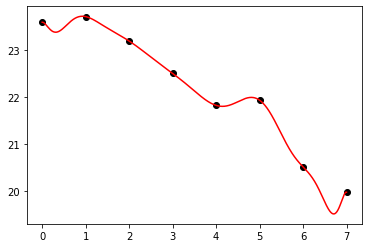

In [ ]:
import matplotlib.pyplot as plt
xns=np.linspace(xs[0],xs[-1],1000)
fns=Pfun(xns)

plt.plot(xs,fs,'ko')
plt.plot(xns,fns,'r-')

## Splines cúbicos

- Como vemos, incluso con interpolación de Hermite no se puede evitar que la función "baile" hacia arriba y hacia abajo de forma descontrolada.

- Existe un método que nos permite realizar una *interpolación limpia* de datos reales y que se conoce como el **método de splines**.

- En este método la función se interpola por tramos, es decir se utiliza un polinomio interpolante por segmentos de la función en lugar de hacerlo en toda la función.  

- El polinomio puede ser de grado 1 (splines lineales), grado 2 (splines cuadráticos) o, el más común, grado 3 (**splines cúbicos**).

- Adicionalmente se impone la condición que los polinomios interpolantes entre conjuntos vecinos de datos tengan la misma derivada en el punto de unión y de esa manera el polinomio sea continuo y derivable (suave y sin saltos de pendientes).

- En la figura abajo se ilustra el método de splines:

<center>
  <img src="https://raw.githubusercontent.com/JorgeZuluaga/NotasMetodosNumericos/master/figuras/splines.png" width=600>
  </center>

### Splines cúbicos con Python


- No profundizaremos aquí en el algoritmo de splines cúbicos sino que nos valdremos de un algoritmo ya implementado en la biblioteca `SciPy`de Pyhton.

- Para ello necesitamos importar el algoritmo `interp1d` así:

In [ ]:
from scipy.interpolate import interp1d

- Ahora necesitamos datos:

In [ ]:
import numpy as np
import pandas as pd
#Leemos los datos
datos=pd.read_csv("dataexport_20220330T141717.csv",skiprows=9)
#Convertimos las fechas en horas desde el primer dato
xs=np.array(pd.to_datetime(datos['timestamp']).view(int)/1e9/3600)
xs=xs-xs[0]
#Extraemos las temperaturas
fs=np.array(datos["Medellín Temperature [2 m elevation corrected]"])

- La interpolación se realiza así:

In [ ]:
Pfun=interp1d(xs,fs,kind='cubic')

In [ ]:
xs

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [ ]:
Pfun(3.45)

array(22.09765487)

- Podemos graficar los datos y el polinomio interpolante (spline):

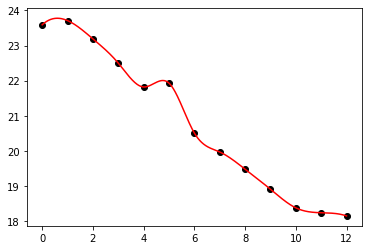

In [ ]:
import matplotlib.pyplot as plt
xns=np.linspace(xs[0],xs[-1],1000)
fns=Pfun(xns)

plt.plot(xs,fs,'ko')
plt.plot(xns,fns,'r-')

- Nótese que ahora el polinomio interpolante no presenta saltos extraños.

### Un ejemplo de splines con una gran serie de datos

- Usando el método de splines cúbicos podemos interpolar grandes bases de datos.

- Tomemos el caso de los datos de temperatura para Medellín descargados del sitio del IDEAM: http://www.pronosticosyalertas.gov.co/datos-abiertos-ideam.

- En el archivo descargado abajo están los datos de pronóstico de temperatura para un período de tiempo de 4 días en Medellín:

In [ ]:
!curl -O https://raw.githubusercontent.com/JorgeZuluaga/NotasMetodosNumericos/master/datos/MEDELLIN.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10427  100 10427    0     0  36079      0 --:--:-- --:--:-- --:--:-- 36079


- Leemos los datos:

In [ ]:
datos=pd.read_csv("MEDELLIN.csv",encoding = "ISO-8859-1")
datos.head(5)

,Cod_Div,Latitud,Longitud,Región,Departamento,Fecha,Hora,Temperatura,Velocidad del Viento,Dirección del Viento,Presión,Punto de Rocío,Cobertura total nubosa,Precipitación (mm/h),Probabilidad de Tormenta,Humedad,Pronóstico
0,5001000,6.248586,-75.576002,NaN,ANTIOQUIA,2022-03-30,09:00,19.9,0.3,1.3,1015.8,19.1,70.0,0.0,0.0,95.2,Parcialmente Nublado
1,5001000,6.248586,-75.576002,NaN,ANTIOQUIA,2022-03-30,10:00,21.2,0.4,303.6,1015.7,20.0,70.0,0.0,0.0,93.1,Parcialmente Nublado
2,5001000,6.248586,-75.576002,NaN,ANTIOQUIA,2022-03-30,11:00,22.0,0.7,283.6,1015.1,20.6,70.0,0.0,0.0,91.8,Parcialmente Nublado
3,5001000,6.248586,-75.576002,NaN,ANTIOQUIA,2022-03-30,12:00,22.6,0.9,270.0,1014.0,20.5,70.0,0.8,0.0,87.9,Parcialmente Nublado - Lluvia Fuerte
4,5001000,6.248586,-75.576002,NaN,ANTIOQUIA,2022-03-30,13:00,23.0,0.8,290.2,1012.3,19.2,70.0,1.5,0.0,79.1,Parcialmente Nublado - Lluvia Fuerte


- Ahora podemos sacar los datos de temperatura:

In [ ]:
fs=datos["Temperatura"]

- Los datos de tiempo son más truculentos de sacar porque tenemos dos columnas, una para la fecha y otra para la hora:

In [ ]:
xs=np.array(pd.to_datetime(datos['Fecha']+" "+datos['Hora']).view(int)/1e9/3600)
xs=xs-xs[0]

- Podemos hacer la interpolación con splines cúbicos:

In [ ]:
Pfun=interp1d(xs,fs,kind='cubic')

- Gráfico:

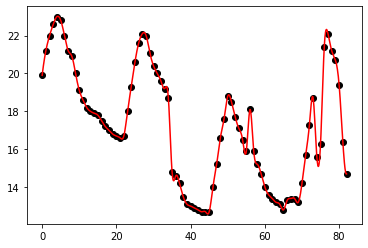

In [ ]:
import matplotlib.pyplot as plt
xns=np.linspace(xs[0],xs[-1],1000)
fns=Pfun(xns)

plt.plot(xs,fs,'ko')
plt.plot(xns,fns,'r-')


## Continuará...

## Ejercicios

- Descargar los datos de temperatura para Medellín estudiados en una clase anterior (https://raw.githubusercontent.com/JorgeZuluaga/NotasMetodosNumericos/master/datos/dataexport_20220330T141717.csv) y usar splines cúbicos para interpolarlos como lo hicimos con los datos de esta clase.

-----
*Fin*